In [1]:
#Remove Background

In [3]:
import numpy as np
import cv2

imgo = cv2.imread('processed2.png')
cv2.imshow("imgo",imgo)


#Removing the background
height, width = imgo.shape[:2]

#Create a mask holder
mask = np.zeros(imgo.shape[:2],np.uint8)

#Grab Cut the object
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

#Hard Coding the Rect… The object must lie within this rect.
rect = (10,10,width-30,height-30)
cv2.grabCut(imgo,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask = np.where((mask==2)|(mask==0),0,1).astype("uint8")
img1 = imgo*mask[:,:,np.newaxis]

#Get the background
background = cv2.absdiff(imgo,img1)

#Change all pixels in the background that are not black to white
background[np.where((background > [0,0,0]).all(axis = 2))] = [255,255,255]

#Add the background and the image
final = background + img1

#To be done – Smoothening the edges….

cv2.imshow('image', final )
cv2.imwrite('input.jpg',final)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
#Preprocess

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


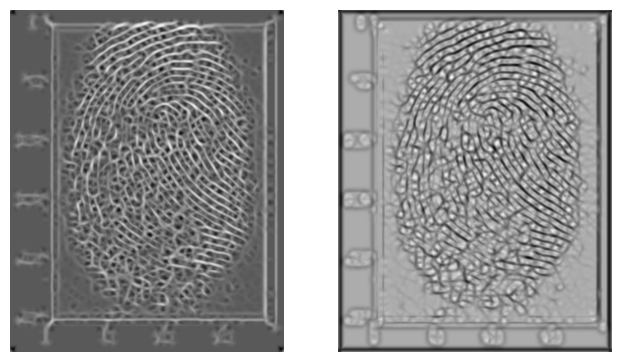

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=3.0):
	H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
	maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
	return maxima_ridges, minima_ridges

def plot_images(*images):
	images = list(images)
	n = len(images)
	fig, ax = plt.subplots(ncols=n, sharey=True)
	for i, img in enumerate(images):
		ax[i].imshow(img, cmap='gray')
		ax[i].axis('off')
		extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
		plt.savefig('fig'+str(i)+'.png', bbox_inches=extent)
	plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
	plt.show()

def main():
	# -------------------------- Step 1: import the image whose background has been removed ----------
	img = cv2.imread("input.jpg",1)

	# -------------------------- Step 2: Sharpen the image -------------------------------------------
	kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
	sharpened = cv2.filter2D(img, -1, kernel)
	# cv2.imshow("sharpened",sharpened)

	# --------------------------- Step 3: Grayscale the image------------------------------------------
	gray = cv2.cvtColor(sharpened,cv2.COLOR_BGR2GRAY)
	# cv2.imshow("gray",gray)

	# --------------------------- Step 4: Perform histogram equilisation ------------------------------
	hist,bins = np.histogram(gray.flatten(),256,[0,256])
	cdf = hist.cumsum()
	cdf_normalized = cdf * hist.max()/ cdf.max()

	cdf_m = np.ma.masked_equal(cdf,0)
	cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
	cdf = np.ma.filled(cdf_m,0).astype('uint8')

	img2=cdf[gray]
	# cv2.imshow("histogram",img2)
	# cv2.imwrite('hist.jpeg',img2)

	# ----------------------------- Step 5: Ridge detection filter ------------------------------------
	#sigma = 2.7
	a, b = detect_ridges(img2, sigma=2.7)
	plot_images(a, b)

	# ----------------------------- Step 6: Convert image to binary image -----------------------------
	img = cv2.imread('fig1.png',0)
	# cv2.imshow("img",img)
	bg = cv2.dilate(img,np.ones((5,5),dtype=np.uint8))
	bg = cv2.GaussianBlur(bg,(5,5),1)
	# cv2.imshow("bg",bg)
	src_no_bg = 255 - cv2.absdiff(img,bg)
	# cv2.imshow("src_no_bg",src_no_bg)
	ret,thresh = cv2.threshold(src_no_bg,240,255,cv2.THRESH_BINARY)
	cv2.imshow("threshold",thresh)
	cv2.imwrite("./threshold.png",thresh)

	# --------------------------- Step 7: Thinning / Skeletonizing Algorithm ----------------------------
	thinned = cv2.ximgproc.thinning(thresh)
	cv2.imshow("thinned",thinned)
	cv2.imwrite("./trial-out.png",thinned)

	cv2.waitKey(0)
	cv2.destroyAllWindows()

if __name__=='__main__':
	main()

In [6]:
#SIFT Detect

In [7]:
import numpy as np
import cv2 as cv
import glob, os

MIN_MATCH_COUNT = 15

#PHOTO TO FIND FEATURE POINTS
# input_img = cv.imread('/home/aastha/CV_Project/Finger-print/2.png')
input_img = cv.imread('./fig1.png')
input_img=input_img.astype('uint8')
gray= cv.cvtColor(input_img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(input_img,None)
img1=cv.drawKeypoints(input_img,kp,input_img)

flag=0

os.chdir("E:\ML\SuperResolution\Datasets\DB3_B")
for file in glob.glob("*.tif"):
    print(file)
    frame=cv.imread(file)
    frame=frame.astype('uint8')
    gray1 = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(frame,None)
    img2=cv.drawKeypoints(frame,kp,frame)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches=flann.knnMatch(np.asarray(des1,np.float32),np.asarray(des2,np.float32),k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>10:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        print("Matched "+str(file))
        flag=1
    else:
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
     cv.imshow("Match",img3)

    cv.waitKey(0)
    cv.destroyAllWindows()

if flag==0:
    print("No Matches among the given set!!")


101_1.tif
101_2.tif
101_3.tif
101_4.tif
101_5.tif
101_6.tif
101_7.tif
101_8.tif
102_1.tif
102_2.tif
102_3.tif
102_4.tif
102_5.tif
102_6.tif
102_7.tif
102_8.tif
103_1.tif
103_2.tif
103_3.tif
103_4.tif
103_5.tif
103_6.tif
103_7.tif
103_8.tif
104_1.tif
104_2.tif
104_3.tif
104_4.tif
104_5.tif
104_6.tif
104_7.tif
104_8.tif
105_1.tif
105_2.tif
105_3.tif
105_4.tif
105_5.tif
105_6.tif
105_7.tif
105_8.tif
106_1.tif
106_2.tif
106_3.tif
106_4.tif
106_5.tif
106_6.tif
106_7.tif
106_8.tif
107_1.tif
107_2.tif
107_3.tif
107_4.tif
107_5.tif
107_6.tif
107_7.tif
107_8.tif
108_1.tif
108_2.tif
108_3.tif
108_4.tif
108_5.tif
108_6.tif
108_7.tif
108_8.tif
109_1.tif
109_2.tif
109_3.tif
109_4.tif
109_5.tif
109_6.tif
109_7.tif
109_8.tif
110_1.tif
Matched 110_1.tif
110_2.tif
110_3.tif
110_4.tif
110_5.tif
110_6.tif
110_7.tif
110_8.tif
